In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import regex as re

#### BatteryManager Processer script

In [2]:
HEADER_PATTERN = 'BatteryMgr:DataCollectionService: onStartCommand: rawFields => '
DATA_PATTERN = 'BatteryMgr:DataCollectionService: stats => '

def preprocess_values(df):
    df['Timestamp'] = df['Timestamp'] - df['Timestamp'][0]
    # conversion from microseconds to seconds
    df['Timestamp'] = df['Timestamp'] / 1000
    return df

def calculate_power(df):
    df['power'] = (abs(df['BATTERY_PROPERTY_CURRENT_NOW']) / 1000 / 1000) * (df['EXTRA_VOLTAGE'] / 1000)
    return df

def trapezoid_method(df):
    return np.trapz(df['power'].values, df['Timestamp'].values), df['Timestamp'].values[-1]


def get_column_names(file):
    pattern = re.compile(HEADER_PATTERN)
    cols = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            cols = line.split(HEADER_PATTERN)[1].split(',')
            cols = [col.strip() for col in cols]
            break
    return cols

def get_data(file):
    pattern = re.compile(DATA_PATTERN)
    data = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            data.append(line.split(DATA_PATTERN)[1].strip('\n').split(','))

    return data

def generate_csv(data_path):
    cols = get_column_names(data_path)
    data = get_data(data_path)
    df = pd.DataFrame(data, columns=cols)
    # df.to_csv('test-paul-controls-bs3/batterymanager.csv', index=False)
    df['Timestamp'] = np.int64(df['Timestamp'])
    df['BATTERY_PROPERTY_CURRENT_NOW'] = np.int64(df['BATTERY_PROPERTY_CURRENT_NOW'])
    df['EXTRA_VOLTAGE'] = np.int64(df['EXTRA_VOLTAGE'])
    df = preprocess_values(df)
    df = calculate_power(df)
    # print(RAW_DATA)
    # print("Energy (J) = ", trapezoid_method(df))
    # df.to_csv(data_path.strip('.log') + '.csv', index=False)
    return df

def process_BM():
    df_aggregated = pd.DataFrame(columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])
    for root, dirs, files in os.walk(".", topdown=False):
        for name in files:
            if name == 'battery_manager.log':
                # print(os.path.join(root, name))
                energy, length = trapezoid_method(generate_csv(os.path.join(root, name)))
                device = root.split('\\')[1]
                app = root.split('\\')[2].strip('-W')
                app_details = root.split('\\')[3]
                is_record = 'record' in root.split('\\')[4]
                is_wireless = '-W' in root.split('\\')[2]
                repetition = root.split('\\')[4].strip('record') if 'record' in root.split('\\')[4] else root.split('\\')[4].strip('replay')
                df_aggregated = pd.concat([df_aggregated, pd.DataFrame([[device, app, app_details, is_record, is_wireless, repetition, energy, length]], columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])])

    # normalized energy consumption for better comparison
    df_aggregated['Energy per Second (J/s)'] = df_aggregated['energy(J)'] / df_aggregated['length(s)']
    return df_aggregated

In [3]:
bm = process_BM().reset_index(drop=True)
bm.to_csv('overall_energy.csv', index=False)

C:\Users\radua\AppData\Local\Temp\ipykernel_32736\2228692058.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aggregated = pd.concat([df_aggregated, pd.DataFrame([[device, app, app_details, is_record, is_wireless, repetition, energy, length]], columns=['device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)'])])


# Plots

### Setting Figure Style

In [4]:
plt.rcParams['font.family'] = 'Arial'
sns.set_style("darkgrid")
sns.set_palette("deep")

### Totals per device

C:\Users\radua\AppData\Local\Temp\ipykernel_32736\873017696.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=bm, x='device', y='Energy per Second (J/s)', showmeans=True, meanline=True, palette='deep')


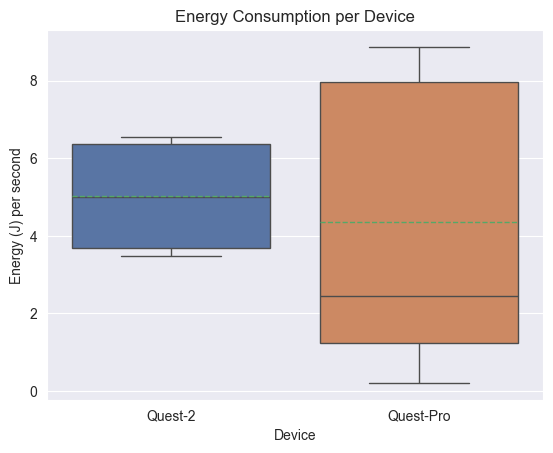

In [5]:
sns.boxplot(data=bm, x='device', y='Energy per Second (J/s)', showmeans=True, meanline=True, palette='deep')
plt.ylabel('Energy (J) per second')
plt.xlabel('Device')
plt.title('Energy Consumption per Device')
plt.show()

C:\Users\radua\AppData\Local\Temp\ipykernel_32736\2002094828.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=q2_bs_runs, x='is_record', y='Energy per Second (J/s)', showmeans=True, meanline=True, palette='deep')
C:\Users\radua\AppData\Local\Temp\ipykernel_32736\2002094828.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


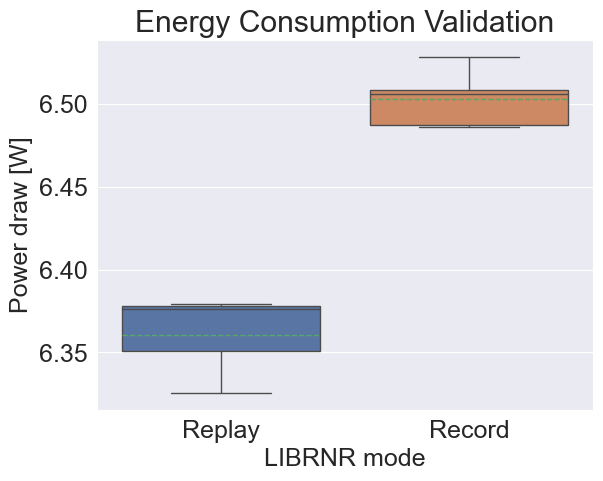

In [6]:
q2_bs_runs = bm[(bm['device'] == 'Quest-2' ) & (bm['is_wireless'] == True) & (bm['app'] == 'BeatSaber') & (bm['app_details'] == 'PopStars-Medium')].reset_index(drop=True)

plt.rcParams.update({'font.size': 18})

ax = sns.boxplot(data=q2_bs_runs, x='is_record', y='Energy per Second (J/s)', showmeans=True, meanline=True, palette='deep')
plt.ylabel('Power draw [W]')
plt.xlabel('LIBRNR mode')
plt.title('Energy Consumption Validation')


labels = ['Replay', 'Record']
ax.set_xticklabels(labels)


plt.show()

### Energy Consumption per Device and App

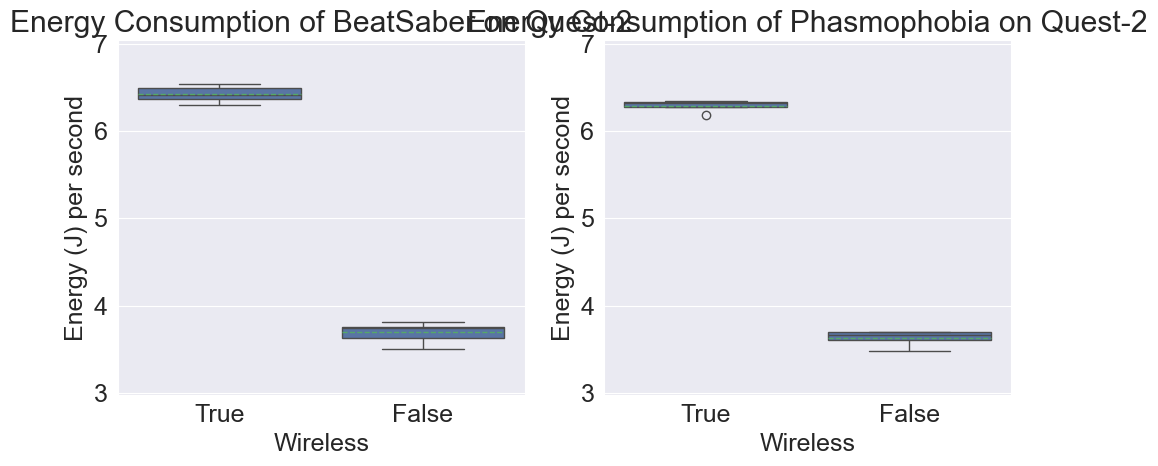

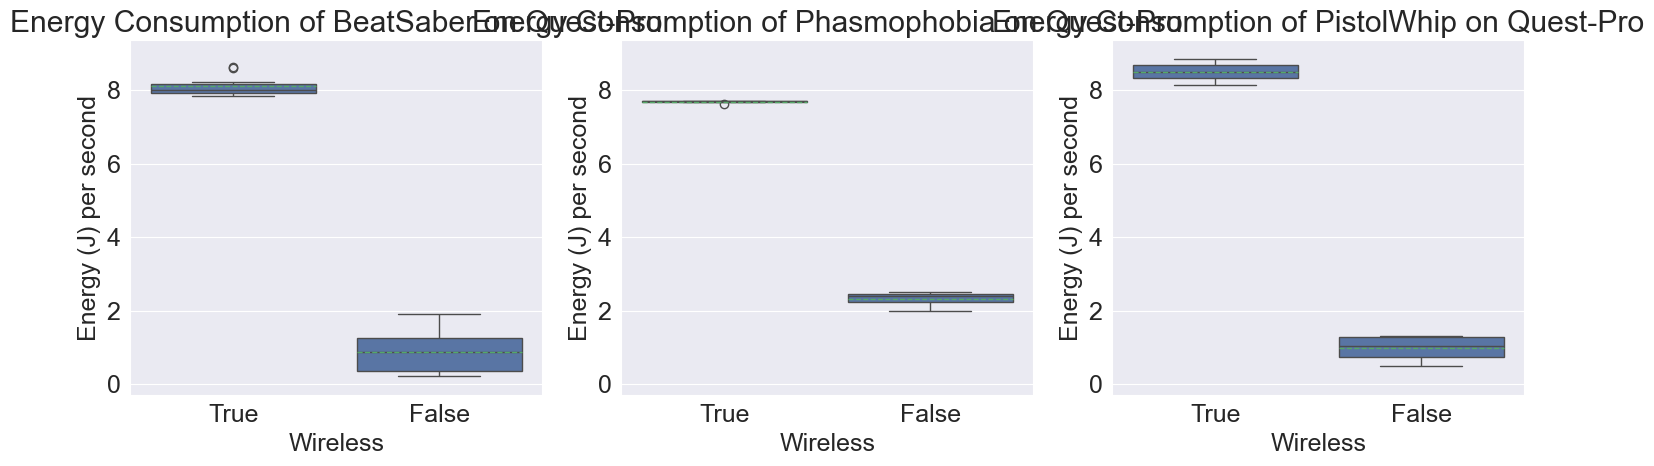

In [7]:
def plot_apps_by_device(df, device):
    df = df[df['device'] == device]
    unique_apps = df['app'].unique()
    num_apps = len(unique_apps)
    fig, axes = plt.subplots(1, num_apps, figsize=(5*num_apps, 5))
    min_energy = df['Energy per Second (J/s)'].min() - 0.5
    max_energy = df['Energy per Second (J/s)'].max() +0.5
    
    for i, app in enumerate(unique_apps):
        ax = axes[i]
        sns.boxplot(data=df[df['app'] == app], x='is_wireless', y='Energy per Second (J/s)', showmeans=True, meanline=True, ax=ax, order=[True, False])
        ax.set_ylabel('Energy (J) per second')
        ax.set_xlabel('Wireless')
        ax.set_title('Energy Consumption of ' + app + ' on ' + device)
        
        ax.set_ylim(min_energy, max_energy)
    
    plt.tight_layout()
    plt.show()

plot_apps_by_device(bm, 'Quest-2')
plot_apps_by_device(bm, 'Quest-Pro')

C:\Users\radua\AppData\Local\Temp\ipykernel_32736\62187930.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_wireless'] == wireless], x='app_details', y='Energy per Second (J/s)', showmeans=True, meanline=True, ax=ax, palette='deep')
C:\Users\radua\AppData\Local\Temp\ipykernel_32736\62187930.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['is_wireless'] == wireless], x='app_details', y='Energy per Second (J/s)', showmeans=True, meanline=True, ax=ax, palette='deep')


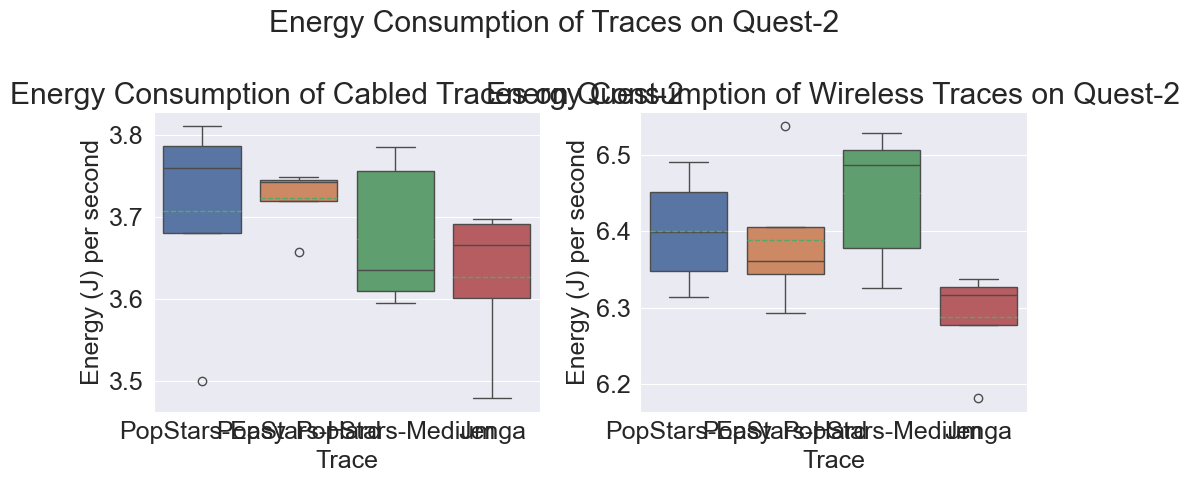

In [8]:
def plot_traces_per_device(df, device):
    df = df[df['device'] == device]
    unique_apps = df['is_wireless'].unique()
    num_apps = len(unique_apps)
    fig, axes = plt.subplots(1, num_apps, figsize=(5*num_apps, 5))
    min_energy = df['Energy per Second (J/s)'].min() - 0.5
    max_energy = df['Energy per Second (J/s)'].max() + 0.5    
    
    for i, wireless in enumerate(unique_apps):
        ax = axes[i]
        sns.boxplot(data=df[df['is_wireless'] == wireless], x='app_details', y='Energy per Second (J/s)', showmeans=True, meanline=True, ax=ax, palette='deep')
        if wireless:
            ax.set_title('Energy Consumption of Wireless Traces on ' + device)
        else:
            ax.set_title('Energy Consumption of Cabled Traces on ' + device)
        ax.set_ylabel('Energy (J) per second')
        ax.set_xlabel('Trace')

        # ax.set_ylim(min_energy, max_energy)
    fig.suptitle('Energy Consumption of Traces on ' + device)
    plt.tight_layout()
    plt.show()

plot_traces_per_device(bm, 'Quest-2')


In [22]:
overall_bm = pd.read_csv('overall_energy.csv')

# make pretty table figure of overall energy consumption
overall_bm['energy [J]'] = overall_bm['energy [J]'].round(2)
overall_bm['length [s]'] = overall_bm['length [s]'].round(2)

overall_bm[(overall_bm['app'] == 'BeatSaber') & (overall_bm['app_details'] == 'PopStars-Hard') & (overall_bm['is_wireless'] == False)].reset_index(drop=True)

,device,app,app_details,is_record,is_wireless,repetition,energy [J],length [s],Power Draw [W]
0,Quest-2,BeatSaber,PopStars-Hard,True,False,0.0,909.14,248.60,3.657061
1,Quest-2,BeatSaber,PopStars-Hard,False,False,0.0,905.20,241.74,3.744503
2,Quest-2,BeatSaber,PopStars-Hard,False,False,0.1,902.48,240.73,3.748957
3,Quest-2,BeatSaber,PopStars-Hard,False,False,0.2,903.99,241.70,3.740162
4,Quest-Pro,BeatSaber,PopStars-Hard,True,False,0.0,451.88,237.68,1.901230
5,Quest-Pro,BeatSaber,PopStars-Hard,False,False,0.0,359.24,292.73,1.227210
6,Quest-Pro,BeatSaber,PopStars-Hard,False,False,0.1,291.87,237.90,1.226853
7,Quest-Pro,BeatSaber,PopStars-Hard,False,False,0.2,278.67,237.82,1.171727
